In [25]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# Load the CIFAR-10 dataset
(x_train, _), (x_test, _) = cifar10.load_data()

In [27]:
# Normalize the images to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [28]:
# Define the latent dimension
latent_dim = 64

# Define the encoder
inputs = layers.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

In [29]:
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

In [30]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [31]:
z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [32]:
# Define the decoder
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(8 * 8 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)

In [33]:
# Build the encoder and decoder models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')

In [34]:
# Define the custom VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Compute the reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(inputs, reconstructed)
        )
        reconstruction_loss *= 32 * 32 * 3
        # Compute the KL divergence loss
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        # Combine the losses
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)
        return reconstructed

In [35]:
# Instantiate and compile the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

In [36]:
# Train the model
history = vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None))

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1989.2245 - val_loss: 1814.5269
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1803.5402 - val_loss: 1787.5104
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1783.3479 - val_loss: 1779.4314
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1774.8276 - val_loss: 1774.0750
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1771.1897 - val_loss: 1770.7806
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1768.6312 - val_loss: 1771.6720
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1764.5657 - val_loss: 1765.1158
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1762.8615 - val_loss: 1764.0782
Epoch 9/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1759.0752 - val_loss: 1762.7218
Epoch 10/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1759.2207 - val_loss: 1761.9266
Epoch 11/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1756.9108 - val

In [37]:
# Evaluate the model
vae.evaluate(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1757.4508


1757.2314453125

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


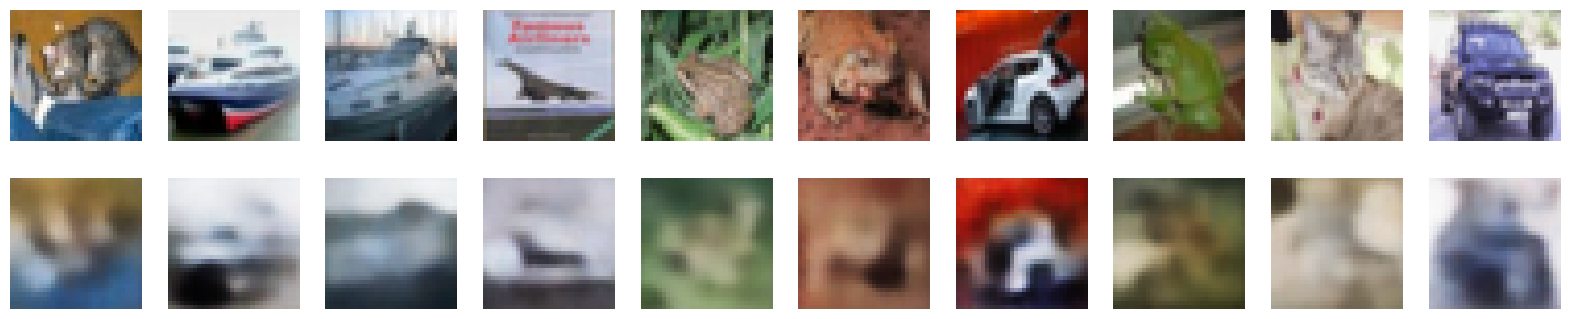

In [38]:
# Visualize the reconstructed images
def plot_reconstructed_images(x_test, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i])
        plt.axis('off')

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        reconstructed_img = vae.predict(np.expand_dims(x_test[i], axis=0))
        plt.imshow(reconstructed_img[0])
        plt.axis('off')

plot_reconstructed_images(x_test)
plt.show()

In [39]:
# Visualize the latent space (for 2D latent space only)
def plot_latent_space(vae, n=30, figsize=15):
    scale = 1.0
    figure = np.zeros((32 * n, 32 * n, 3))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            img = x_decoded[0].reshape(32, 32, 3)
            figure[i * 32: (i + 1) * 32, j * 32: (j + 1) * 32] = img

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure)
    plt.axis('off')
    plt.show()

# Uncomment the following line if latent_dim == 2
# plot_latent_space(vae)